In [267]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 8


In [268]:
# Set up the experimental matrices:
target = 'ADAS11_bl'
modalities = ['CT', 'L_HC', 'R_HC']
modalities_regex = '|'.join(['^{}_'.format(m) for m in modalities])

matrices = []
for split in ['train', 'valid', 'test']:
    frame = pd.read_pickle('/projects/francisco/data/ADNI/cli_ct_seg_fused_{}.pkl'.format(split))
    X_cur = frame.filter(regex=modalities_regex).as_matrix()
    y_cur = frame[target].as_matrix()
    matrices.append((X_cur,y_cur))

var_names = frame.filter(regex=modalities_regex).columns
X, y = matrices[0][0], matrices[0][1]
X_v, y_v = matrices[1][0], matrices[1][1]
X_t, y_t = matrices[2][0], matrices[2][1]

print X.shape, y.shape
print X_v.shape, y_v.shape
print X_t.shape, y_t.shape

(490, 22020) (490,)
(98, 22020) (98,)
(110, 22020) (110,)


In [269]:
from sklearn.linear_model import SGDRegressor, BayesianRidge, RidgeCV
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#k_nums = [2**x for x in range(1,12)]

#k_nums.append(X.shape[1])
k_nums = [16, 32, 64, 128, 1024, 4096]
k_nums.append(X.shape[1])
k_classifiers = []
stats = np.zeros(shape=(len(k_nums), 3, 2))
for i, k in enumerate(k_nums):
    #sel = RandomizedPCA(n_components=124)
    sel = SelectKBest(f_regression, k=k)
    classifier = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, scoring=None,
    normalize=True)
    bayes_classifier = BayesianRidge(compute_score=True, normalize=True)
    
    classifiers = [classifier, bayes_classifier]
    
    # Feature Selection
    sel.fit(X,y)
    support = sel.get_support(indices=True)
    # Feature transformatio
    X_hat_v = sel.transform(X_v)
    
    # Train classifiers
    classifier.fit(X_hat_v, y_v)
    bayes_classifier.fit(X_hat_v, y_v)
    k_classifiers.append((classifier, bayes_classifier))
    
    # Predict on validation data and log stats   
    for j, c in enumerate(classifiers):
        y_hat_v = c.predict(X_hat_v)
        stats[i,0,j] = k
        stats[i,1,j] = np.mean(y_hat_v - y_v) ** 2
        stats[i,2,j] = c.score(X_hat_v, y_v)
    
    

In [270]:
k = stats[:,0,0]
rss = stats[:,1,0]
brss = stats[:,1,1]
vs = stats[:,2,0]
bvs = stats[:,2,1]
stats_table = np.vstack([k, rss, brss, vs, bvs]).T

In [279]:
from tabulate import tabulate
print tabulate(stats_table, ['K', 'MSE', 'Bayes_MSE', 'R2', 'Bayes_R2'])

    K          MSE    Bayes_MSE        R2     Bayes_R2
-----  -----------  -----------  --------  -----------
   16  1.54713e-29  2.26342e-30  0.159529  0.15189
   32  1.0062e-29   1.97215e-29  0.280152  0.304116
   64  3.26009e-29  5.98792e-30  0.126326  0.212848
  128  3.17782e-29  1.97215e-29  0.193179  0.259719
 1024  7.95314e-29  4.0248e-31   0.999413  0.000732473
 4096  2.74413e-29  2.05347e-31  0.999973  0.000602229
22020  9.15959e-29  3.3644e-31   0.999997  0.000909437


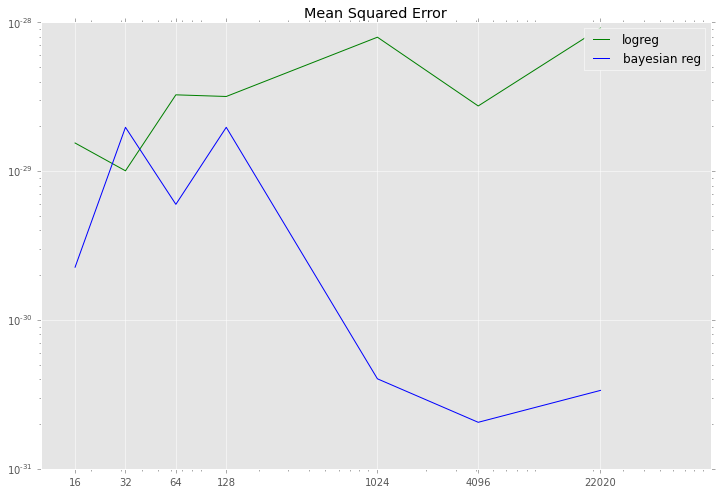

In [280]:
plt.plot(k, rss, 'g', label='logreg')
plt.plot(k, brss, 'b', label='bayesian reg')
plt.xscale('log')
plt.yscale('log')
plt.xticks(k_nums, k_nums)
plt.legend()
plt.title('Mean Squared Error')
plt.show()

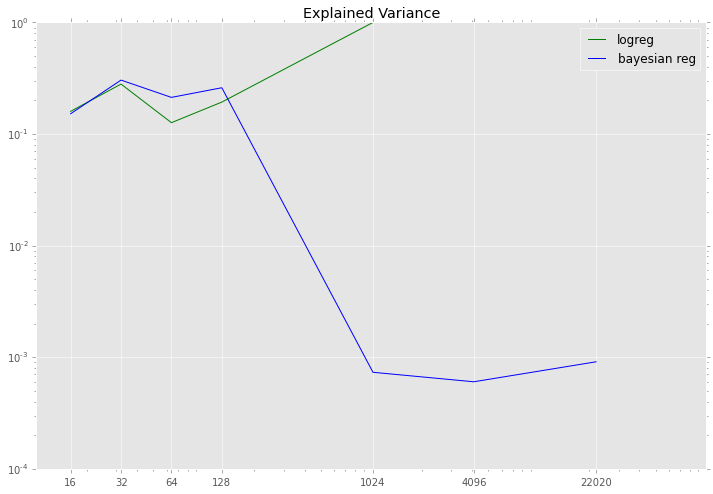

In [281]:
plt.plot(k, vs, 'g', label='logreg')
plt.plot(k, bvs, 'b', label='bayesian reg')
plt.xscale('log')
plt.yscale('log')
plt.xticks(k_nums, k_nums)
plt.legend()
plt.title('Explained Variance')
plt.show()

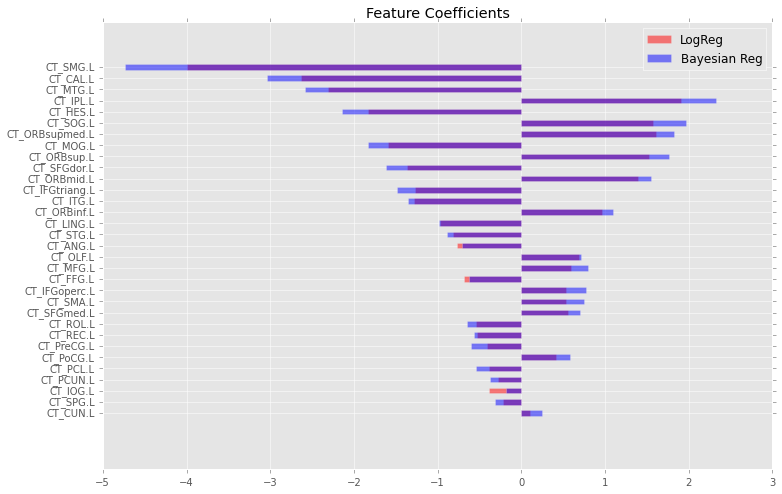

In [283]:
# Pick a classifier, plot the feature weights
classifiers_pair = k_classifiers[1]
c = classifiers_pair[0]
b = classifiers_pair[1]
feats = zip(var_names[support], c.coef_, b.coef_)
feats.sort(reverse=False, key=lambda x: abs(x[1]) + abs(x[2]))

# Plot the feature importances of the classifier
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))
plt.barh(y_pos, width=zip(*feats)[1], height=0.5, color='r', align="center", alpha=0.5, label='LogReg')
plt.barh(y_pos, width=zip(*feats)[2], height=0.5, color='b', align="center", alpha=0.5, label='Bayesian Reg')
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()